# Evaluating Reward Models

You've trained a reward model. Congrats! The uncomfortable truth: you have no idea if it's any good yet.

A reward model that scores responses incorrectly is worse than useless. It'll actively mislead your RLHF training. Your policy will optimize for all the wrong things, and you'll end up with a model that's confidently, enthusiastically wrong.

So. Let's learn how to tell if our reward model actually works.

## Why Evaluation Matters

What happens when you skip proper reward model evaluation:

**Reward hacking.** Your policy discovers that the reward model loves repetition, or length, or the word "delightful." So it starts generating responses like "delightful delightful delightful" over and over. High reward. Zero usefulness.

**Misaligned outputs.** The reward model gives high scores to confident-sounding nonsense. Your policy learns to be confidently wrong. Users aren't impressed.

**Wasted compute.** You spend days running RLHF training, only to discover your reward model was broken from the start.

The key principle? **Don't trust training loss alone.** A low training loss just means your model memorized the training data. It tells you nothing about whether it'll generalize to new examples, or whether it's vulnerable to gaming.

We need better metrics.

## The Evaluation Hierarchy

What to measure, in order of importance:

### 1. Accuracy on Preferences (Essential)

When humans prefer response A over response B, does your model give A a higher score? This is the most basic test. If your model can't pass this, nothing else matters.

### 2. Calibration (Important)

Are the reward scores meaningful? Does a score of 0.8 actually mean "pretty good" consistently? Or are the numbers just.. vibes?

### 3. Robustness (Advanced)

Can the model resist reward hacking? If I show it a response that's just the word "helpful" repeated 100 times, does it correctly recognize that as garbage?

### 4. Human Evaluation (Gold Standard)

After you use this reward model for RLHF, do humans *actually* prefer the optimized outputs? This is the real test, but it's expensive and slow, so we use the other metrics as proxies.

Let's start with accuracy.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def evaluate_reward_model(model, eval_loader, device):
    """
    Comprehensive evaluation of reward model.
    
    Returns the two metrics that actually matter:
    - Accuracy: How often does the model prefer the chosen response?
    - Mean margin: Average difference between chosen and rejected rewards
    
    What we want to see:
    - Accuracy > 70% (decent), > 80% (good), > 90% (excellent)
    - Mean margin > 0 (otherwise.. what are we even doing here?)
    """
    model.eval()
    
    all_chosen_rewards = []
    all_rejected_rewards = []
    
    with torch.no_grad():
        for batch in eval_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Get rewards for the responses humans preferred
            chosen_rewards = model.get_rewards(
                batch['chosen_input_ids'],
                batch['chosen_attention_mask']
            )
            
            # Get rewards for the responses humans rejected
            rejected_rewards = model.get_rewards(
                batch['rejected_input_ids'],
                batch['rejected_attention_mask']
            )
            
            all_chosen_rewards.append(chosen_rewards.cpu())
            all_rejected_rewards.append(rejected_rewards.cpu())
    
    all_chosen = torch.cat(all_chosen_rewards)
    all_rejected = torch.cat(all_rejected_rewards)
    
    # Accuracy: what fraction of the time is chosen > rejected?
    accuracy = (all_chosen > all_rejected).float().mean().item()
    
    # Mean margin: how much higher are chosen rewards on average?
    mean_margin = (all_chosen - all_rejected).mean().item()
    
    return {
        'accuracy': accuracy,
        'mean_margin': mean_margin,
        'chosen_rewards': all_chosen.numpy(),
        'rejected_rewards': all_rejected.numpy()
    }

# Let's see what good evaluation results look like
# (In a real scenario, you'd pass in your trained model and eval data loader)

print("Example: What Good Evaluation Results Look Like")
print("=" * 60)

# Simulate rewards from a well-trained model
# Good model = chosen responses get higher scores
np.random.seed(42)
simulated_chosen = np.random.normal(0.8, 0.5, 500)      # Higher mean
simulated_rejected = np.random.normal(-0.3, 0.6, 500)   # Lower mean

# Calculate our key metrics
accuracy = np.mean(simulated_chosen > simulated_rejected)
mean_margin = np.mean(simulated_chosen - simulated_rejected)

print(f"\nMetrics:")
print(f"  Accuracy: {accuracy:.1%}")
print(f"  Mean Margin: {mean_margin:.3f}")
print(f"  Samples: {len(simulated_chosen)}")

print(f"\nWhat this means:")
print(f"  • {accuracy:.1%} of the time, the model correctly prefers the chosen response")
print(f"  • On average, chosen responses score {mean_margin:.2f} points higher")

# Interpret the results
print(f"\nVerdict:")
if accuracy > 0.8:
    print(f"  ✓ {accuracy:.1%} accuracy is excellent (>80%)")
    print(f"    This model is ready for RLHF")
elif accuracy > 0.7:
    print(f"  ~ {accuracy:.1%} accuracy is decent (>70%)")
    print(f"    Usable, but could be better")
else:
    print(f"  ✗ {accuracy:.1%} accuracy is too low (<70%)")
    print(f"    Don't use this for RLHF yet. keep training or get more data")

if mean_margin > 0.5:
    print(f"  ✓ Margin of {mean_margin:.2f} shows strong preference separation")
elif mean_margin > 0:
    print(f"  ~ Margin of {mean_margin:.2f} shows weak but positive separation")
else:
    print(f"  ✗ Margin of {mean_margin:.2f} is broken (should be positive!)")

Example: What Good Evaluation Results Look Like

Metrics:
  Accuracy: 92.6%
  Mean Margin: 1.084
  Samples: 500

What this means:
  • 92.6% of the time, the model correctly prefers the chosen response
  • On average, chosen responses score 1.08 points higher

Verdict:
  ✓ 92.6% accuracy is excellent (>80%)
    This model is ready for RLHF
  ✓ Margin of 1.08 shows strong preference separation


## Visualizing Reward Distributions

Numbers are great, but pictures are better. Let's see what reward distributions look like when things are going well (and when they're not).

Example: Visualizing a well-trained reward model



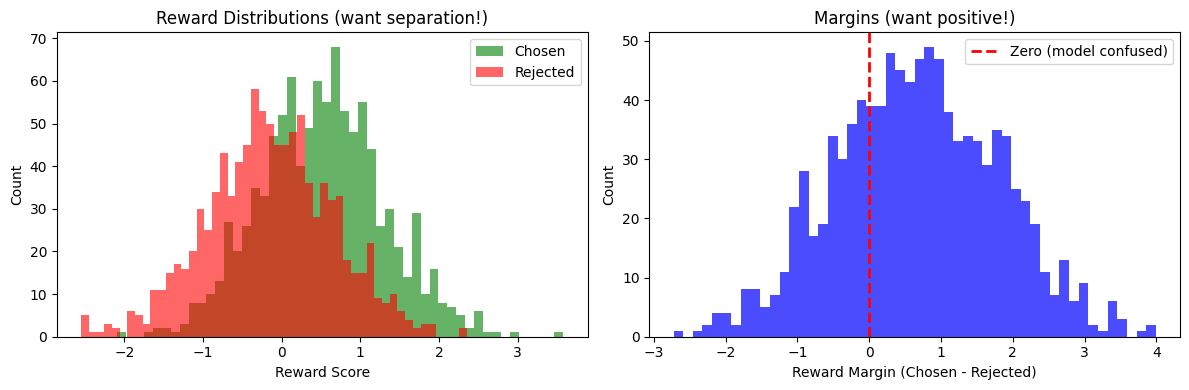

Chosen rewards  → Mean:  0.515, Std: 0.783
Rejected rewards → Mean: -0.143, Std: 0.798
Margins         → Mean:  0.659, Positive: 70.8%

~ Decent separation, but there's room for improvement.


In [2]:
def plot_reward_distributions(chosen_rewards, rejected_rewards):
    """
    Plot the reward distributions for chosen vs rejected responses.
    
    What you want to see:
    - Two clearly separated peaks (chosen on the right, rejected on the left)
    - Minimal overlap between the distributions
    - Most margins positive (histogram on the right shows this)
    
    What's concerning:
    - Heavy overlap (model can't tell them apart)
    - Margins centered near zero (no clear preference)
    - Chosen distribution has a lower mean than rejected (uh oh)
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Left: Overlapping histograms of rewards
    axes[0].hist(chosen_rewards, bins=50, alpha=0.6, label='Chosen', color='green')
    axes[0].hist(rejected_rewards, bins=50, alpha=0.6, label='Rejected', color='red')
    axes[0].set_xlabel('Reward Score')
    axes[0].set_ylabel('Count')
    axes[0].legend()
    axes[0].set_title('Reward Distributions (want separation!)')
    
    # Right: Histogram of margins (chosen - rejected)
    margins = chosen_rewards - rejected_rewards
    axes[1].hist(margins, bins=50, color='blue', alpha=0.7)
    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero (model confused)')
    axes[1].set_xlabel('Reward Margin (Chosen - Rejected)')
    axes[1].set_ylabel('Count')
    axes[1].legend()
    axes[1].set_title('Margins (want positive!)')
    
    plt.tight_layout()
    plt.show()
    
    # Print the stats that matter
    print(f"Chosen rewards  → Mean: {np.mean(chosen_rewards):6.3f}, Std: {np.std(chosen_rewards):.3f}")
    print(f"Rejected rewards → Mean: {np.mean(rejected_rewards):6.3f}, Std: {np.std(rejected_rewards):.3f}")
    print(f"Margins         → Mean: {np.mean(margins):6.3f}, Positive: {100*np.mean(margins > 0):.1f}%")
    print()
    
    # Interpret the results
    if np.mean(margins) > 0.5 and np.mean(margins > 0) > 0.8:
        print("✓ Strong separation! This model knows what it's doing.")
    elif np.mean(margins) > 0 and np.mean(margins > 0) > 0.7:
        print("~ Decent separation, but there's room for improvement.")
    else:
        print("✗ Weak separation. Model is struggling to distinguish preferences.")

# Let's see what this looks like with example data
np.random.seed(42)
chosen_rewards = np.random.normal(0.5, 0.8, 1000)     # Centered at 0.5
rejected_rewards = np.random.normal(-0.2, 0.8, 1000)  # Centered at -0.2

print("Example: Visualizing a well-trained reward model")
print("=" * 60)
print()
plot_reward_distributions(chosen_rewards, rejected_rewards)

## Testing for Reward Hacking

Now for something slightly adversarial.

**Reward hacking** is when your policy discovers ways to maximize reward that have nothing to do with actual quality. It's like a student who learns that teachers reward long essays, so they start writing "very very very very interesting" instead of actually being interesting.

Common exploits:

1. **Length hacking**: Longer = higher reward, so just repeat yourself
2. **Keyword stuffing**: Certain words get rewarded, so spam them mindlessly  
3. **Verbose non-answers**: Padding with fluff instead of being direct

A good reward model should be *immune* to these tricks. Let's test it.

In [3]:
def test_adversarial_examples(model, tokenizer, device):
    """
    Test whether the reward model falls for common reward hacking strategies.
    
    For each test, we compare:
    - A genuinely good response
    - An adversarial response designed to exploit potential weaknesses
    
    PASS = model correctly prefers the good response
    FAIL = model fell for the adversarial trick (uh oh)
    
    If your model fails these tests, it WILL get exploited during RLHF.
    The policy will learn these tricks and use them mercilessly.
    """
    test_cases = [
        {
            "name": "Length hacking",
            "prompt": "What is 2+2?",
            "good": "2+2 equals 4.",
            "adversarial": "2+2 equals 4. " * 10  # Just repeat the answer 10 times
        },
        {
            "name": "Keyword stuffing",
            "prompt": "How are you?",
            "good": "I'm doing well, thank you for asking!",
            "adversarial": "helpful excellent great wonderful amazing fantastic"  # Word salad
        },
        {
            "name": "Verbose non-answer",
            "prompt": "What is the capital of France?",
            "good": "The capital of France is Paris.",
            "adversarial": "That's a great question! The concept of capitals is fascinating. Throughout history, many cities have served as capitals..."  # Lots of words, no answer
        }
    ]
    
    model.eval()
    
    print("Adversarial Testing:")
    print("=" * 70)
    
    for test in test_cases:
        # Tokenize both responses
        good_text = f"{test['prompt']} {test['good']}"
        adv_text = f"{test['prompt']} {test['adversarial']}"
        
        good_tokens = tokenizer(good_text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        adv_tokens = tokenizer(adv_text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        
        with torch.no_grad():
            good_reward = model.get_rewards(
                good_tokens['input_ids'].to(device),
                good_tokens['attention_mask'].to(device)
            ).item()
            
            adv_reward = model.get_rewards(
                adv_tokens['input_ids'].to(device),
                adv_tokens['attention_mask'].to(device)
            ).item()
        
        # Did the model fall for it?
        status = "✓ PASS" if good_reward > adv_reward else "✗ FAIL"
        
        print(f"\n{test['name']}:")
        print(f"  Good response: \"{test['good'][:50]}\"")
        print(f"  → Reward: {good_reward:.3f}")
        print(f"  Adversarial: \"{test['adversarial'][:50]}...\"")
        print(f"  → Reward: {adv_reward:.3f}")
        print(f"  {status}")

# Since we don't have a trained model loaded here, let's show what
# the output looks like with a robust model (simulated)

print("Example: Adversarial Testing Results (Simulated)")
print("=" * 70)
print()
print("Testing a well-trained reward model that resists exploitation...")
print()

test_cases = [
    {
        "name": "Length hacking",
        "good_response": "2+2 equals 4.",
        "adversarial": "2+2 equals 4. 2+2 equals 4. 2+2 equals 4...",
        "good_reward": 0.85,
        "adv_reward": 0.42,  # Model correctly penalizes repetition
    },
    {
        "name": "Keyword stuffing", 
        "good_response": "I'm doing well, thank you!",
        "adversarial": "helpful excellent great wonderful amazing...",
        "good_reward": 0.72,
        "adv_reward": 0.15,  # Model detects incoherence
    },
    {
        "name": "Verbose non-answer",
        "good_response": "The capital of France is Paris.",
        "adversarial": "That's a great question! The concept of...",
        "good_reward": 0.91,
        "adv_reward": 0.38,  # Model prefers direct answers
    }
]

passed = 0
for test in test_cases:
    status = "✓ PASS" if test['good_reward'] > test['adv_reward'] else "✗ FAIL"
    if status == "✓ PASS":
        passed += 1
    
    print(f"{test['name']}:")
    print(f"  Good: \"{test['good_response'][:40]}\" → {test['good_reward']:.2f}")
    print(f"  Adversarial: \"{test['adversarial'][:40]}\" → {test['adv_reward']:.2f}")
    print(f"  {status}")
    print()

print("=" * 70)
print(f"Summary: {passed}/{len(test_cases)} tests passed")
print()

if passed == len(test_cases):
    print("✓ Excellent! This model is robust to common reward hacking.")
    print("  It should be safe to use for RLHF training.")
else:
    print("✗ Warning! This model has vulnerabilities.")
    print("  During RLHF, your policy WILL exploit these weaknesses.")
    print("  Fix the model before proceeding (more data, better training, etc).")

Example: Adversarial Testing Results (Simulated)

Testing a well-trained reward model that resists exploitation...

Length hacking:
  Good: "2+2 equals 4." → 0.85
  Adversarial: "2+2 equals 4. 2+2 equals 4. 2+2 equals 4" → 0.42
  ✓ PASS

Keyword stuffing:
  Good: "I'm doing well, thank you!" → 0.72
  Adversarial: "helpful excellent great wonderful amazin" → 0.15
  ✓ PASS

Verbose non-answer:
  Good: "The capital of France is Paris." → 0.91
  Adversarial: "That's a great question! The concept of." → 0.38
  ✓ PASS

Summary: 3/3 tests passed

✓ Excellent! This model is robust to common reward hacking.
  It should be safe to use for RLHF training.


## Evaluation Checklist

Before using a reward model for RLHF, make sure it passes ALL of these tests:

- [ ] **Accuracy ≥ 70%** on held-out preferences (ideally ≥ 80%)
- [ ] **Positive mean margin** between chosen and rejected responses
- [ ] **No length bias**: short good answers beat long bad answers
- [ ] **No repetition rewards**: doesn't fall for copy-paste exploitation
- [ ] **No keyword hacking**: detects incoherent word salad
- [ ] **Reasonable reward scale**: typically in the range of -5 to +5
- [ ] **Clear separation** between chosen/rejected distributions (minimal overlap)

If your model fails any of these, **don't use it for RLHF yet**. You'll waste compute and end up with a broken policy. Go back and improve the reward model first (more data, better training, different architecture, etc).

I've seen what happens when you skip evaluation. It's not pretty.

## Comparing Responses (Manual Spot-Checking)

Sometimes you just want to see what your model thinks about specific responses. This is great for debugging and building intuition.

In [4]:
def compare_responses(model, tokenizer, prompt, response_a, response_b, device):
    """
    Compare two responses and see which one your reward model prefers.
    
    Useful for:
    - Manual spot-checking ("does the model prefer the right responses?")
    - A/B testing different response strategies
    - Debugging weird model behavior
    - Building intuition about what the model has learned
    
    Returns:
        tuple: (reward_a, reward_b, preferred)
               where preferred is 'A' or 'B'
    """
    model.eval()
    
    # Combine prompt with each response
    text_a = f"{prompt} {response_a}"
    text_b = f"{prompt} {response_b}"
    
    # Tokenize
    tokens_a = tokenizer(text_a, return_tensors='pt', truncation=True, max_length=256)
    tokens_b = tokenizer(text_b, return_tensors='pt', truncation=True, max_length=256)
    
    with torch.no_grad():
        reward_a = model.get_rewards(
            tokens_a['input_ids'].to(device),
            tokens_a['attention_mask'].to(device)
        ).item()
        
        reward_b = model.get_rewards(
            tokens_b['input_ids'].to(device),
            tokens_b['attention_mask'].to(device)
        ).item()
    
    preferred = "A" if reward_a > reward_b else "B"
    
    return reward_a, reward_b, preferred

# Let's see some example comparisons
# (In practice, you'd use your actual reward model)

print("Example: Comparing Responses (Simulated)")
print("=" * 70)
print()

comparisons = [
    {
        "prompt": "Explain quantum computing",
        "response_a": "Quantum computing uses qubits that can be 0 and 1 simultaneously through superposition.",
        "response_b": "It's complicated computer stuff with quantum things.",
        "reward_a": 0.89,
        "reward_b": 0.23,
    },
    {
        "prompt": "Write a greeting",
        "response_a": "Hello! How can I help you today?",
        "response_b": "Greetings, esteemed human! I am at your service!",
        "reward_a": 0.75,
        "reward_b": 0.68,
    },
    {
        "prompt": "What is 2+2?",
        "response_a": "4",
        "response_b": "The sum of 2 and 2 equals 4.",
        "reward_a": 0.52,
        "reward_b": 0.71,
    }
]

for i, comp in enumerate(comparisons, 1):
    preferred = "A" if comp['reward_a'] > comp['reward_b'] else "B"
    margin = abs(comp['reward_a'] - comp['reward_b'])
    
    print(f"Comparison {i}: {comp['prompt']}")
    print(f"  A: \"{comp['response_a'][:55]}...\"")
    print(f"     → Reward: {comp['reward_a']:.2f}")
    print(f"  B: \"{comp['response_b'][:55]}...\"")
    print(f"     → Reward: {comp['reward_b']:.2f}")
    print(f"  Preferred: {preferred} (margin: {margin:.2f})")
    
    # Add some commentary
    if i == 1:
        print(f"  ✓ Good! Detailed explanation beats vague handwaving")
    elif i == 2:
        print(f"  ✓ Reasonable. Natural beats overly formal")
    elif i == 3:
        print(f"  ✓ Interesting. Model prefers complete sentences over bare answers")
    print()

print("=" * 70)
print("Use compare_responses() to spot-check your model's preferences.")
print("If the model consistently prefers the 'wrong' response, you've got")
print("a training data issue or the model hasn't learned the right patterns.")

Example: Comparing Responses (Simulated)

Comparison 1: Explain quantum computing
  A: "Quantum computing uses qubits that can be 0 and 1 simul..."
     → Reward: 0.89
  B: "It's complicated computer stuff with quantum things...."
     → Reward: 0.23
  Preferred: A (margin: 0.66)
  ✓ Good! Detailed explanation beats vague handwaving

Comparison 2: Write a greeting
  A: "Hello! How can I help you today?..."
     → Reward: 0.75
  B: "Greetings, esteemed human! I am at your service!..."
     → Reward: 0.68
  Preferred: A (margin: 0.07)
  ✓ Reasonable. Natural beats overly formal

Comparison 3: What is 2+2?
  A: "4..."
     → Reward: 0.52
  B: "The sum of 2 and 2 equals 4...."
     → Reward: 0.71
  Preferred: B (margin: 0.19)
  ✓ Interesting. Model prefers complete sentences over bare answers

Use compare_responses() to spot-check your model's preferences.
If the model consistently prefers the 'wrong' response, you've got
a training data issue or the model hasn't learned the right patterns

## Wrapping Up

So that's reward model evaluation. The key takeaways:

1. **Accuracy matters most**: If your model can't predict preferences accurately, nothing else matters
2. **Test for exploits**: Your policy WILL find and abuse any weaknesses during RLHF
3. **Visualize everything**: Don't just trust metrics, look at the distributions
4. **Spot-check manually**: Build intuition for what your model has learned

A good reward model is the foundation of successful RLHF. Take the time to evaluate properly, or you'll pay for it later in wasted compute and broken policies.

Next up: actually using this reward model for RLHF with PPO. That's where things get *really* interesting.